In [1]:
import tensorflow as tf
import os
import numpy as np

In [2]:
def prepare_local_file(file):
    labeled_sentences = []
    with open(file, "r") as f:
        for line in f:
            trans_file, sentence, label = line.strip().split('\t')
            labeled_sentences.append((sentence, label))
    return labeled_sentences

In [3]:
labeled_sentences = prepare_local_file("training_files/rnn_lj_data_training_13Feb.txt")
sentences = [s for (s, l) in labeled_sentences]
labels = [int(l) for (s, l) in labeled_sentences]
print(len(sentences))

9925


In [4]:
libri_labeled_sentences = prepare_local_file("training_files/rnn_libri_data_training_13Feb.txt")
libri_sentences = [s for (s, l) in libri_labeled_sentences]
libri_labels = [int(l) for (s, l) in libri_labeled_sentences]
print(len(libri_sentences))

12000


In [5]:
sentences = sentences + libri_sentences
labels = labels + libri_labels
print(len(sentences))
print(len(labels))

21925
21925


In [6]:
for (s,l) in zip(sentences[0:100], labels[0:100]):
    print("Sentence: {}".format(s))
    print("Label: {}".format(l))
    print("\n")

Sentence: at last he decided to enlist one tester a clerk in the traffic department whom he thought would prove a likely tool
Label: 1


Sentence: between the small producer the small trader the consumer
Label: 1


Sentence: francis was sentenced to be hanged decapitated and quartered
Label: 1


Sentence: a coat among them much torn and stained with three buttons missing one of which corresponded with that picked up at hampstead
Label: 1


Sentence: convicted offenders might have good or bad luck they might be arraigned when their particular crime was uncommon and were then nearly certain to escape
Label: 1


Sentence: as this was accomplished beyond the limits of the metropolis and its perpetrators arraigned at hertford
Label: 1


Sentence: but as it was the persians came upon them by surprise and so took the city
Label: 1


Sentence: on the west end of the house is the attached garage which can be reached from the kitchen or from the outside
Label: 1


Sentence: at length the ordinar

In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_counts)
print("vocabulary size: {:d}".format(vocab_size))
word2idx = tokenizer.word_index
idx2word = {v:k for (k, v) in word2idx.items()}

vocabulary size: 26998


In [8]:
print(list(word2idx.items())[0:10])
print(list(idx2word.items())[0:10])

[('the', 1), ('of', 2), ('and', 3), ('to', 4), ('a', 5), ('in', 6), ('was', 7), ('that', 8), ('he', 9), ('it', 10)]
[(1, 'the'), (2, 'of'), (3, 'and'), (4, 'to'), (5, 'a'), (6, 'in'), (7, 'was'), (8, 'that'), (9, 'he'), (10, 'it')]


In [9]:
seq_lengths = np.array([len(s.split()) for s in sentences])
print([(p, np.percentile(seq_lengths, p)) for p
in [75, 80, 90, 95, 99, 100]])

[(75, 38.0), (80, 40.0), (90, 45.0), (95, 48.0), (99, 54.0), (100, 69.0)]


In [10]:
max_seqlen = 69
# create dataset
sentences_as_ints = tokenizer.texts_to_sequences(sentences) #transform to sequences of indices
sentences_as_ints = tf.keras.preprocessing.sequence.pad_sequences(sentences_as_ints, maxlen=max_seqlen, padding= "post")  #pad some 0(s) or truncate
labels_as_ints = np.array(labels)
dataset = tf.data.Dataset.from_tensor_slices((sentences_as_ints, labels_as_ints))

In [12]:
dataset = dataset.shuffle(9000)
test_size = int(0.3 * len(sentences))
# test_size_2 = int(0.15 * len(sentences))
val_size = int(0.10 * len(sentences))
test_dataset = dataset.take(test_size)
# test_dataset_2 = dataset.skip(test_size).take(test_size_2)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size)
batch_size = 128
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
# test_dataset_2 = test_dataset_2.batch(batch_size)

In [13]:
print(len(sentences))
print(test_size)
# print(test_size_2)
print(val_size)

21925
6577
2192


### <span style="color:#0b486b">Building up and training the model</span> ###

In [14]:
embed_size = 32
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embed_size,
                           mask_zero=True, # padded 0(s) at the end of each sequence of indices will be ignored during training
                           input_shape=[None]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(), 'accuracy'])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)

Epoch 1/20
103/103 [==============================] - 13s 128ms/step - loss: 0.4784 - precision: 0.2817 - recall: 0.0089 - accuracy: 0.8271 - val_loss: 0.6259 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7258
Epoch 2/20
103/103 [==============================] - 10s 93ms/step - loss: 0.4466 - precision: 1.0000 - recall: 4.3975e-04 - accuracy: 0.8272 - val_loss: 0.5450 - val_precision: 1.0000 - val_recall: 0.0081 - val_accuracy: 0.7203
Epoch 3/20
103/103 [==============================] - 10s 100ms/step - loss: 0.3819 - precision: 0.6779 - recall: 0.1426 - accuracy: 0.8412 - val_loss: 0.4623 - val_precision: 0.9930 - val_recall: 0.2163 - val_accuracy: 0.7664
Epoch 4/20
103/103 [==============================] - 9s 87ms/step - loss: 0.3022 - precision: 0.7421 - recall: 0.4315 - accuracy: 0.8788 - val_loss: 0.3998 - val_precision: 0.9557 - val_recall: 0.4131 - val_accuracy: 0.8266
Epoch 5/20
103/103 [==============================] - 9s 87ms/step - loss: 0.2470 -

In [ ]:
# model.save('./models')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          400992    
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 417,665
Trainable params: 417,665
Non-trainable params: 0
_________________________________________________________________


In [15]:
results = model.evaluate(test_dataset)

52/52 [==============================] - 2s 32ms/step - loss: 0.0439 - precision: 0.9852 - recall: 0.9703 - accuracy: 0.9875


In [19]:
print(history.history.keys())

dict_keys(['loss', 'precision', 'recall', 'accuracy', 'val_loss', 'val_precision', 'val_recall', 'val_accuracy'])


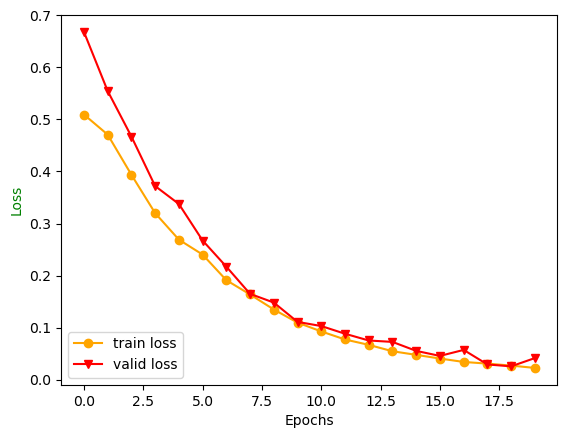

In [16]:
#loss graph
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# ax1.plot(history.history['recall'], label='train recall', color='green', marker="o")
# ax1.plot(history.history['val_recall'], label='valid recall', color='blue', marker = "v")
ax1.plot(history.history['loss'], label = 'train loss', color='orange', marker="o")
ax1.plot(history.history['val_loss'], label = 'valid loss', color='red', marker = "v")
ax1.legend(loc=3)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
# ax2.set_ylabel('Loss', color='b')
# ax2.legend(loc=4)
#plt.ylim([0.0, 2.5])
plt.show()

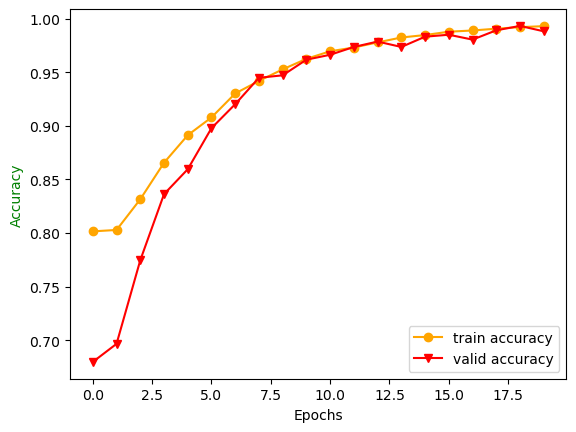

In [17]:
fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# ax1.plot(history.history['recall'], label='train recall', color='green', marker="o")
# ax1.plot(history.history['val_recall'], label='valid recall', color='blue', marker = "v")
ax1.plot(history.history['accuracy'], label = 'train accuracy', color='orange', marker="o")
ax1.plot(history.history['val_accuracy'], label = 'valid accuracy', color='red', marker = "v")
ax1.legend(loc=4)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='g')
# ax2.set_ylabel('Loss', color='b')
# ax2.legend(loc=4)
#plt.ylim([0.0, 2.5])
plt.show()

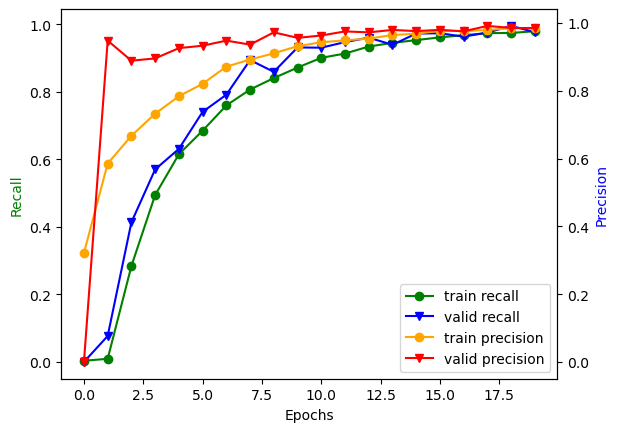

In [18]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ln1 = ax1.plot(history.history['recall'], label='train recall', color='green', marker="o")
ln2 = ax1.plot(history.history['val_recall'], label='valid recall', color='blue', marker = "v")
ln3 = ax2.plot(history.history['precision'], label = 'train precision', color='orange', marker="o")
ln4 = ax2.plot(history.history['val_precision'], label = 'valid precision', color='red', marker = "v")

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
# ax1.legend(loc=0)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Recall', color='g')
ax2.set_ylabel('Precision', color='b')
# ax2.legend(loc=4)
#plt.ylim([0.0, 2.5])
plt.show()

### <span style="color:#0b486b">Produce values for Cof. Matrix</span> ###

In [16]:
test_x = []
test_y = []
for x, y in test_dataset:
    test_x.append(x)
    test_y.append(y)
# print(test_x)
test_x = np.concatenate(test_x, axis=0)
test_y = np.concatenate(test_y, axis=0)

In [17]:
from sklearn.metrics import confusion_matrix

y_prediction = (model.predict(test_x) > 0.5).astype("int32")
y_true = test_y
y_prediction = np.transpose(y_prediction)[0]
tn, fp, fn, tp = confusion_matrix(y_true, y_prediction).ravel()
print(tn, fp, fn, tp)

4681 31 68 1797


### <span style="color:#0b486b">Manual Model Test</span> ###

In [17]:
sentences_test_2_arr = []
labels_test_2_arr = []
for sentences_test_2, labels_test_2 in test_dataset:  # only take first element of dataset
    for sen in sentences_test_2.numpy():
        sentences_test_2_arr.append(sen)
    for lab in labels_test_2.numpy():
        labels_test_2_arr.append(lab)
print(len(labels_test_2_arr))

6577


In [18]:
index = 0
sentences_str = []
sen_ints_all = []
for sen_ints in sentences_test_2_arr:
#     if index == 2:
#         break
    temp_str = ""
    probs = (model.predict(np.array( [sen_ints,] )) > 0.5).astype("int32")
#     print(probs[0][0])
#     print(labels_test_2[index].numpy())
    for ints in sen_ints:
        if ints == 0:
            continue
        temp_str = temp_str + " " + list(idx2word.items())[ints-1][1]
    sentences_str.append((temp_str, [labels_test_2_arr[index], probs[0][0]]))
    index = index + 1
# print(sentences_str)

In [20]:
print(sentences_str[1000:1510])

[(' because the stairway itself is enclosed neither baker nor truly could see anything on the secondfloor hallway until they reached the landing at the top of the stairs', [0, 0]), (' since the calamitous event he went on that happened at hertford i have been a lost man', [0, 0]), (' circulation metabolism excretion oxygenation', [0, 0]), (' the policemen were now in possession', [0, 0]), (' powers considered oswald to be meek and easily led', [0, 0]), (' but the session was far advanced and the matter was relegated to the following year', [0, 0]), (' the only revolver made by smith and wesson with this serial number when first manufactured it had a fiveinch barrel', [0, 0]), (' hence as jordan has said the inside of an animal tells the real history of its ancestry the outside tells us only where its ancestors have been', [0, 0]), (' because she thought the fbi was in possession of a great deal of information and certainly would find it very easy to learn where oswald was living', [0, 

In [25]:
truep = 0
truen = 0
falsep = 0
falsen = 0
for case in sentences_str:
    prediction = case[1]
    if prediction[0] == 0 and prediction[1] == 0:
        truen = truen + 1
    elif prediction[0] == 1 and prediction[1] == 1:
        truep = truep + 1
    elif prediction[0] == 1 and prediction[1] == 0:
        falsen = falsen + 1
    elif prediction[0] == 0 and prediction[1] == 1:
        falsep = falsep + 1
print(truen, falsep, falsen, truep)

2653 4 2 318
